# 결과 미리 요약
- 05번 실험 모델보다 조금 떨어지지만 나쁘지는 않음  
- 하지만 open을 closed로 오분류 하는게 엄청 많음 617개

In [1]:
import os
import random
import numpy as np
import tensorflow as tf

SEED=42
os.environ["PYTHONHASHSEED"]=str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

gpus=tf.config.experimental.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
plt.rcParams["font.family"]="Malgun Gothic"
plt.rcParams["axes.unicode_minus"]=False
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
IMG_SIZE=86
BATCH_SIZE=32
DATA_PATH="../../data/processed/02_kaggle_dataset/train"

datagen=ImageDataGenerator(
    rescale=1./255,
    brightness_range=[0.9, 1.1],
    rotation_range=10,
    zoom_range=0.1,  # 0.2 -> 0.1 다시 줄임
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode="nearest",
    horizontal_flip=False,
    validation_split=0.2
)

train_generator=datagen.flow_from_directory(
    DATA_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="training",
    shuffle=True,
    seed=SEED
)

val_generator=datagen.flow_from_directory(
    DATA_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="validation",
    shuffle=False
)

Found 38400 images belonging to 2 classes.
Found 9600 images belonging to 2 classes.


In [3]:
model=Sequential([
    Conv2D(64, 3, activation="relu", input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(96, 3, activation="relu"),
    BatchNormalization(),
    MaxPooling2D(2),

    Flatten(),
    Dense(32, activation="relu", kernel_regularizer=l2(0.001)),
    Dropout(0.4),  # FC에만 적용
    Dense(1, activation="sigmoid")
])

model.compile(optimizer=Adam(learning_rate=0.0005),
            loss="binary_crossentropy", metrics=["accuracy"])

In [4]:
history=model.fit(train_generator, validation_data=val_generator,
                epochs=20, verbose=1)

Epoch 1/20
1200/1200 [==============================] - 99s 77ms/step - loss: 0.3958 - accuracy: 0.8929 - val_loss: 0.5519 - val_accuracy: 0.7977
Epoch 2/20
1200/1200 [==============================] - 81s 68ms/step - loss: 0.2555 - accuracy: 0.9380 - val_loss: 0.4910 - val_accuracy: 0.8769
Epoch 3/20
1200/1200 [==============================] - 84s 70ms/step - loss: 0.2071 - accuracy: 0.9570 - val_loss: 0.5490 - val_accuracy: 0.8074
Epoch 4/20
1200/1200 [==============================] - 85s 71ms/step - loss: 0.1904 - accuracy: 0.9653 - val_loss: 1.0768 - val_accuracy: 0.6349
Epoch 5/20
1200/1200 [==============================] - 75s 62ms/step - loss: 0.1802 - accuracy: 0.9711 - val_loss: 1.7977 - val_accuracy: 0.6854
Epoch 6/20
1200/1200 [==============================] - 79s 66ms/step - loss: 0.1679 - accuracy: 0.9743 - val_loss: 0.7219 - val_accuracy: 0.7364
Epoch 7/20
1200/1200 [==============================] - 85s 71ms/step - loss: 0.1565 - accuracy: 0.9760 - val_loss: 1.2003 -

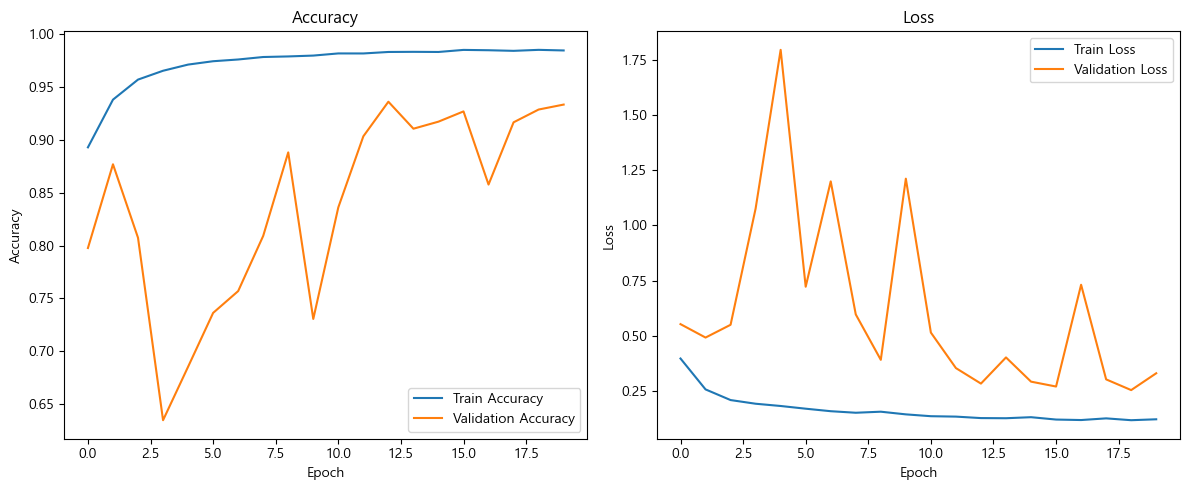

In [5]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.savefig("../../results/images/04_readjusted_training_plot.png")
plt.show()

              precision    recall  f1-score   support

      closed       0.89      0.99      0.94      4800
        open       0.99      0.87      0.93      4800

    accuracy                           0.93      9600
   macro avg       0.94      0.93      0.93      9600
weighted avg       0.94      0.93      0.93      9600



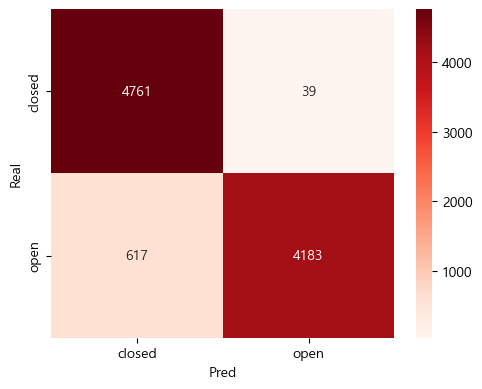

In [6]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

y_true=val_generator.classes
steps=val_generator.samples // val_generator.batch_size + 1
y_pred_prob=model.predict(val_generator, steps=steps, verbose=0)
y_pred=(y_pred_prob > 0.5).astype(int)

# classification report
report=classification_report(y_true, y_pred, target_names=["closed", "open"])
print(report)
with open("../../results/reports/04_readjusted_classification_report.txt", "w") as f:
    f.write(report)

# confusion matrix
conf_matirx=confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matirx, annot=True, fmt="d", cmap="Reds",
            xticklabels=["closed", "open"], yticklabels=["closed", "open"])
plt.xlabel("Pred")
plt.ylabel("Real")
plt.tight_layout()
plt.savefig("../../results/images/04_readjusted_confusion_matrix.png")
plt.show()